In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models


transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to 224x224
    transforms.ToTensor(), # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize images
])
train_path = "anomaly-dataset/train/"
test_path = "anomaly-dataset/test"

train_data = datasets.ImageFolder(root = train_path, transform=transform)
test_data  = datasets.ImageFolder(root = test_path, transform=transform)


loaders = {
    "train" : DataLoader(train_data,
                        batch_size = 32,
                        shuffle = True,
                        num_workers = 1),
    "test"  : DataLoader(test_data,
                        batch_size = 32,
                        shuffle = True,
                        num_workers = 1)
}

In [2]:
class AnomalyDetection(nn.Module):
    max_channels = 20
    def __init__(self, in_channels, out_channels, batch_size):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, out_channels, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.glob_avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.linear1 = nn.Linear(out_channels, 1)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(self.glob_avg_pool(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.linear1(x))

        return torch.sigmoid(x)

In [3]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models


device = torch.device("cuda")
model = AnomalyDetection(3, 20, 32)
# model = models.mobilenet_v3_large(weights="DEFAULT")

# for param in model.parameters():
#     param.requires_grad = False

model.to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.01)
loss_fn = nn.BCELoss()

# model.classifier[3] = nn.Linear(1280, 1)
# model.classifier.add_module("4", nn.Sigmoid())



In [4]:
def train(model, epoch):
    model.train()
    for num_batch, (data, label) in enumerate(loaders["train"]):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, label.unsqueeze(1).float().to(device))
        loss.backward()
        optimizer.step()
        if num_batch % 10 == 0:
            print(f"Train epoch: {epoch} [{num_batch * len(data)}/{len(loaders['train'].dataset)} ({100. * num_batch / len(loaders['train']):.0f}%)]\t{loss.item():.6f}")


def test(model):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders["test"]:
            data, target = data.to(device), target.to(device)
            output = model(data)
            target = target.float()
            test_loss += loss_fn(output, target.unsqueeze(1).float()).item() * len(data) # Multiply by batch size to get total loss for the batch
            pred = (output >= 0.5).squeeze() # Remove the extra dimension
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss/=len(loaders["test"].dataset)
    print(f"\nTest Set: Average Loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders['test'].dataset)} ({100* correct / len(loaders['test'].dataset):.0f}%\n)")

In [193]:
for epoch in range(1, 5):
    train(model, epoch)
    test(model)

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train epoch: 1 [0/1588 (0%)]	0.693147
Train epoch: 1 [320/1588 (20%)]	0.693147
Train epoch: 1 [640/1588 (40%)]	0.693147
Train epoch: 1 [960/1588 (60%)]	0.693147
Train epoch: 1 [1280/1588 (80%)]	0.693147

Test Set: Average Loss: 0.6931, Accuracy 85/216 (39%
)
Train epoch: 2 [0/1588 (0%)]	0.693147
Train epoch: 2 [320/1588 (20%)]	0.693147
Train epoch: 2 [640/1588 (40%)]	0.693147
Train epoch: 2 [960/1588 (60%)]	0.693147
Train epoch: 2 [1280/1588 (80%)]	0.693147


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Test Set: Average Loss: 0.6931, Accuracy 85/216 (39%
)
Train epoch: 3 [0/1588 (0%)]	0.693147
Train epoch: 3 [320/1588 (20%)]	0.693147
Train epoch: 3 [640/1588 (40%)]	0.693147


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train epoch: 3 [960/1588 (60%)]	0.693147
Train epoch: 3 [1280/1588 (80%)]	0.693147

Test Set: Average Loss: 0.6931, Accuracy 85/216 (39%
)
Train epoch: 4 [0/1588 (0%)]	0.693147
Train epoch: 4 [320/1588 (20%)]	0.693147
Train epoch: 4 [640/1588 (40%)]	0.693147
Train epoch: 4 [960/1588 (60%)]	0.693147


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train epoch: 4 [1280/1588 (80%)]	0.693147

Test Set: Average Loss: 0.6931, Accuracy 85/216 (39%
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Normal


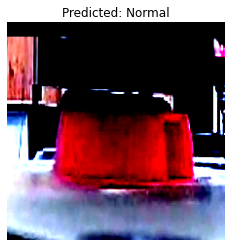

In [59]:
import random
import matplotlib.pyplot as plt
from torchvision import transforms

model.eval()
preds = ['Anomaly', "Normal"]

# Get a random sample from the dataset
index = random.randint(0, len(test_data) - 1)
data, target = test_data[index]


# Add batch dimension and move to device
data = data.unsqueeze(0).to(device)

# Inference
output = model(data)
pred = (output >= 0.5)
print(f"Label: {preds[target]}")

# Convert the image tensor for display
# Assuming the tensor shape is [1, 28, 28] (grayscale), we squeeze and use matplotlib
image = data.squeeze(0).permute(1,2,0).cpu().numpy()

# Plotting the image
plt.imshow(image, cmap='gray')
plt.title(f"Predicted: {preds[pred]}")
plt.axis('off')
plt.show()